# Neo-Hookean Solid Model

This module provides a testing for the Neo-Hookean solid model, 
which is widely used in the simulation of nonlinear elastic materials.

## References

- T. Belytschko, W. K. Liu, B. Moran, and K. Elkhodary, 
"Nonlinear Finite Elements for Continua and Structures". Wiley, 2014. 
Available: [Google Books](https://books.google.com/books?id=BQpfAQAAQBAJ)

- [Neo-Hookean solid on Wikipedia](https://en.m.wikipedia.org/wiki/Neo-Hookean_solid)

## Equations

The equation for $\psi$, the strain energy density function, is given by Eq. 5.4.54 in the reference:

$$
\psi(\mathbf{C}) = \frac{\lambda_0}{2} (\ln(J))^2 - \mu_0 \ln(J) + \frac{\mu_0}{2} (\text{tr} \mathbf{C} - 3)
$$

where:

- $\lambda_0$ is the first Lamé parameter from the linearized theory,
- $\mu_0$ is the shear modulus from the linearized theory,
- $J$ is the determinant of the deformation gradient tensor,
- $\mathbf{C}$ is the right Cauchy-Green deformation tensor.

The equation for $\tau$, the first Piola-Kirchhoff stress tensor, is given by Eq. 5.4.54 in the reference:

$$
\tau = \lambda_0 \ln(J) \mathbf{I} + \mu_0 (\mathbf{B} - \mathbf{I})
$$

where:

- $\mathbf{I}$ is the identity matrix,
- $\mathbf{B}$ is the left Cauchy-Green deformation tensor.

Properties used herein are representative of natural rubber as detailed in the references.
## Uniaxial tension

With uniaxial tension, we can solve for $J$ and $\lambda_2$ as a function of $\lambda_1$.

We have:

$$
\tau_{11} = \lambda_0 \ln(J) + \mu_0 (\lambda_1^2 - 1.0) \neq 0.0
$$

and:

$$
\tau_{22} = \tau_{33} = 0 = \lambda_0 \ln(J) + \mu_0 (\lambda_2^2 - 1.0)
$$

$$
\tau_{12} = \tau_{13} = \tau_{23} = 0.0
$$

where:
- $\tau_{ij}$ is the first Piola-Kirchhoff stress tensor
- $\lambda_1$ is the stretch in the 1-direction,
- $\mu_0$ is the shear modulus,
- $\lambda_0$ is the first Lamé parameter.

The deformation gradient tensor is given by:

$$
F = \text{diag}(\lambda_1, \lambda_2, \lambda_2)
$$

The determinant of the deformation gradient tensor is given by:

$$
J = \lambda_1 \lambda_2^2
$$

The left Cauchy-Green deformation tensor is given by:

$$
\mathbf{B} = \begin{bmatrix} \lambda_1^2 & 0.0 & 0.0 \\ 0.0 & \lambda_2^2 & 0.0 \\ 0.0 & 0.0 & \lambda_2^2 \end{bmatrix}
$$

We can find an equation for $J$ as a function of $\lambda_1$ using the above equations:
rearranging the equation for $J$ gives:

$$
\lambda_2^2 = J / \lambda_1
$$

Substituting this into the equation for $\tau_{22}$ and $\tau_{33}$ gives:

$$
0 = \lambda_0 \ln(J) + \mu_0 (J / \lambda_1 - 1.0)
$$

Rearranging this equation gives:

$$
0 = \ln(J) + \frac{\mu_0}{\lambda_0} (J / \lambda_1 - 1.0)
$$

$$
0 = \ln(J) + J \frac{\mu_0}{\lambda_0 \lambda_1} - \mu_0 / \lambda_0
$$

That gives us a nonlinear equation we can use to solve for $J$. After we have $J$ we can find $\lambda_2$ and $\tau_{11}$:

$$
\lambda_2 = \sqrt{J / \lambda_1}
$$

and

$$
\tau_{11} = \lambda_0 \ln(J) + \mu_0 (\lambda_1^2 - 1.0)
$$

We will set up an equation to use with a nonlinear solver to find $J$

### Script to calculate the uniaxial tension stress

In [4]:
# Import necessary libraries
import numpy as np
from scipy.optimize import fsolve
import matplotlib.pyplot as plt

# Define constants
bulk_modulus = 2.2e9    # Pa. [2]
mu = 1.5e6              # Pa. [2]
lame_lambda = bulk_modulus - 2.0/3.0 * mu
youngs_modulus = 9.0 * mu * bulk_modulus / (3.0 * bulk_modulus + mu)
poissons_ratio = (3.0 * bulk_modulus - 2.0 * mu) / (2.0 * (3.0 * bulk_modulus + mu))
print(f"Young's modulus: {youngs_modulus/1.0e6} MPa")
print(f"Poisson's ratio: {poissons_ratio}")

# Nonlinear equation for J in uniaxial tension
def uniaxial_tension_equation_for_J(J, lambda_1, mu, lame_lambda):
    return np.log(J) + mu / lame_lambda * J / lambda_1 - mu / lame_lambda

# Compute the first Piola-Kirchhoff stress for a given displacement gradient
def compute_first_piola_kirchhoff_stress(du_dX):
    # Compute the deformation gradient
    F = du_dX + np.eye(3)

    # Compute the left Cauchy-Green deformation tensor
    B = np.dot(F, F.T)

    # Compute the determinant of F
    J = np.linalg.det(F)

    # Compute the first Piola-Kirchhoff stress
    tau = lame_lambda * np.log(J) * np.eye(3) + mu * (B - np.eye(3))

    return tau

# Function to compute the Cauchy stress and infinitesimal strain for a given stretch
def compute_stress_for_uniaxial_tension(lambda_1):
    # Setup and solve the nonlinear equation for J
    J_initial_guess = 1.0
    J_solution = fsolve(uniaxial_tension_equation_for_J, J_initial_guess, args=(lambda_1, mu, lame_lambda))
    J = J_solution[0]

    # Compute the stretch in the other two directions
    lambda_2 = np.sqrt(J / lambda_1)
    print(f'lambda_1: {lambda_1}, lambda_2: {lambda_2}')

    # Compute the deformation gradient
    F = np.diag([lambda_1, lambda_2, lambda_2])

    # Compute the displacement gradient
    du_dX = F - np.eye(3)

    # Compute the first Piola-Kirchhoff stress
    tau = compute_first_piola_kirchhoff_stress(du_dX)

    # Compute the Cauchy stress
    sigma = 1.0 / J * tau

    # Make sure all components of tau except tau_11 are zero
    for i in range(3):
        for j in range(3):
            if i == 0 and j == 0:
                continue
            if np.abs(tau[i, j]) > 1.0e-8 * np.abs(tau[0, 0]):
                print(f'Warning: tau[{i}, {j}] is not zero. Value: {tau[i, j]}')

    # Compute the infinitesimal strain tensor
    epsilon = 0.5 * (du_dX + du_dX.T)

    return epsilon, sigma


# Compute the stress and strain for a range of stretch ratios
def sweep_lambda_for_uniaxial_tension():
    lambda_1 = np.linspace(0.1, 5.0, 99)
    e_11 = []
    e_22 = []
    sigma_11 = []

    for l in lambda_1:
        e, s = compute_stress_for_uniaxial_tension(l)
        e_11.append(e[0,0])
        e_22.append(e[1,1])
        sigma_11.append(s[0,0]/1.0e6)

    return lambda_1, e_11, e_22, sigma_11

Young's modulus: 4.4989775051124745 MPa
Poisson's ratio: 0.4996591683708248


In [5]:
def check_results():
    e, s = compute_stress_for_uniaxial_tension(1.0)
    if np.abs(e[0,0] - 0.0) > 1.0e-8:
        return False
    return True

lambda_1: 0.1, lambda_2: 3.1526510534584102
lambda_1: 0.15000000000000002, lambda_2: 2.5770260189395593
lambda_1: 0.2, lambda_2: 2.2330298281101517
lambda_1: 0.25, lambda_2: 1.9979602188952443
lambda_1: 0.30000000000000004, lambda_2: 1.8242927721963567
lambda_1: 0.35, lambda_2: 1.6892402788893632
lambda_1: 0.4, lambda_2: 1.5803315080675153
lambda_1: 0.45000000000000007, lambda_2: 1.4900916418018892
lambda_1: 0.5, lambda_2: 1.4137319638017742
lambda_1: 0.55, lambda_2: 1.348023968989028
lambda_1: 0.6, lambda_2: 1.2907012740393
lambda_1: 0.65, lambda_2: 1.2401198158388507
lambda_1: 0.7000000000000001, lambda_2: 1.1950540851645612
lambda_1: 0.75, lambda_2: 1.154569389460369
lambda_1: 0.8, lambda_2: 1.1179387436956534
lambda_1: 0.85, lambda_2: 1.0845870605797558
lambda_1: 0.9, lambda_2: 1.0540526384915299
lambda_1: 0.9500000000000001, lambda_2: 1.0259599483906163
lambda_1: 1.0, lambda_2: 1.0
lambda_1: 1.05, lambda_2: 0.9759159125249497
lambda_1: 1.1, lambda_2: 0.9534921342797538
lambda_1: 1

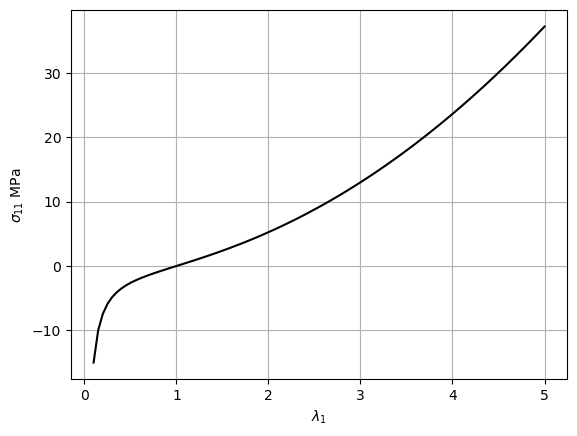

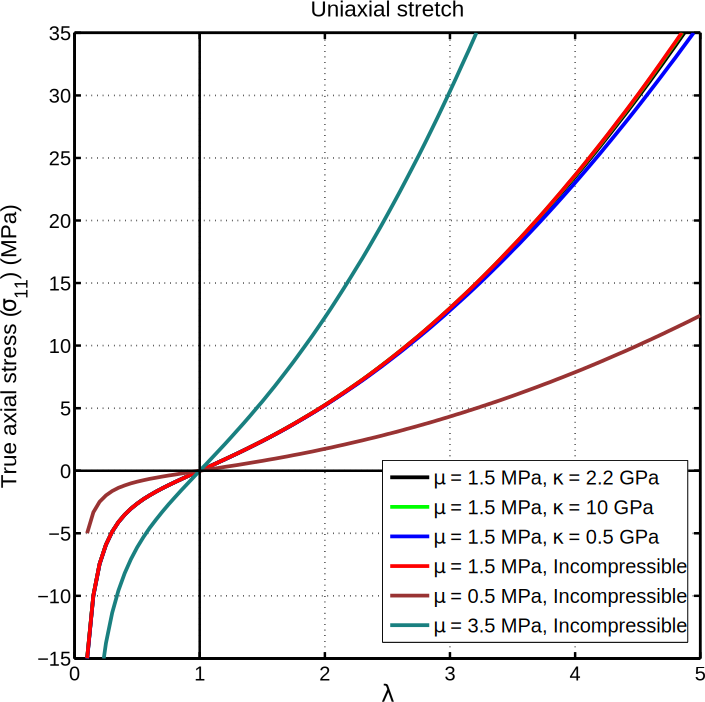

In [6]:
from IPython.display import SVG

# Sweep the stretch ratio for uniaxial tension
lambda_1, e_11, e_22, sigma_11 = sweep_lambda_for_uniaxial_tension()

# Plot the results, lambda_1 vs sigma_11A
plt.plot(lambda_1, sigma_11, color = 'black')
plt.xlabel("$\\lambda_{1}$")
plt.ylabel("$\\sigma_{11}$ MPa")
plt.grid()

plt.show()

# Reference plot, line with mu = 1.5 MPa and lambda = 2.2 GPa
SVG(url='https://upload.wikimedia.org/wikipedia/commons/8/8d/CompNeoHook.svg')
